# CNN

dataset: https://www.kaggle.com/datasets/ozguraslank/brain-stroke-ct-dataset?resource=download

Reference used to read dataset:
* https://www.kaggle.com/code/ozguraslank/reading-brain-stroke-ct-dataset



In [1]:
import numpy as np  # Biblioteca para operaciones numéricas y manejo de arreglos
import matplotlib.pyplot as plt  # Biblioteca para visualización de datos en gráficos
import pandas as pd  # Biblioteca para manipulación y análisis de datos en estructuras tabulares
from sklearn.svm import SVC  # Clasificador de soporte vectorial (Support Vector Classification)
from sklearn.model_selection import GridSearchCV  # Herramienta para optimización de hiperparámetros
from sklearn.model_selection import train_test_split  # Función para dividir datos en conjuntos de entrenamiento y prueba
from sklearn.metrics import accuracy_score  # Métrica para calcular la precisión del modelo
from sklearn.metrics import classification_report, confusion_matrix  # Reporte que muestra métricas de clasificación
import os  # Módulo para interactuar con el sistema operativo
from PIL import Image  # Biblioteca para abrir, manipular y guardar imágenes
import seaborn as sns # Biblioteca para visualización de datos en gráficos


## Data processing 

In [ ]:
path = 'Brain_Stroke_CT_Dataset/'

#Path de las imágenes
normal_path = path + "Normal" + "/" + "PNG" #Debe ser así pa q funcione tipo expresion regular
ischemia_path = path + "Ischemia" + "/" + "PNG"
bleeding_path = path + "Bleeding" + "/" + "PNG"

#Path de las máscaras
ischemia_mask_path = path + "Ischemia" + "/" + "OVERLAY"
bleeding_mask_path = path + "Bleeding" + "/" + "OVERLAY"

#Obtenemos todas las imágenes
normal_folder = os.listdir(normal_path)
ischemia_folder = os.listdir(ischemia_path)
bleeding_folder = os.listdir(bleeding_path)

#Obtenemos todas las máscaras
ischemia_mask_folder = os.listdir(ischemia_mask_path)
bleeding_mask_folder = os.listdir(bleeding_mask_path)

#Mostramos cantidad de datos por clase para ver desbalance
size_normal = len(normal_folder)
size_ischemia = len(ischemia_folder)
size_bleeding = len(bleeding_folder)
print("Normal:", size_normal)
print("Ischemia:", size_ischemia)
print("Bleeding:", size_bleeding)


Normal: 4427
Ischemia: 1130
Bleeding: 1093


In [4]:
def process_image(file_path, dim, scale):
    img = Image.open(file_path)
    img = img.convert(scale) #Escala de grises o RGB
    img = img.resize(dim) #Reescalamos
    img = np.array(img)
    return img

In [5]:
#Almacenamos todas las imágenes
data = []
dim = (256, 256) #resize

folders = [normal_folder, ischemia_folder, bleeding_folder]
paths = [normal_path, ischemia_path, bleeding_path]

for i in range(len(folders)):

    #Recorremos todos los archivos de la carpeta y path i 
    for file_name in folders[i]:
        img = process_image(paths[i] + "/" + file_name, dim, 'L') #L = escala de grises
        data.append(img)

#También almacenamos las máscaras
mask_folders = [ischemia_mask_folder, bleeding_mask_folder]
mask_paths = [ischemia_mask_path, bleeding_mask_path]
masks = []
for i in range(len(mask_folders)):

    #Recorremos todos los archivos de la carpeta y path i
    counter = 0
    for file_name in mask_folders[i]:

        if i == 0 and counter == 534:
            print(file_name)

        img = process_image(mask_paths[i] + "/" + file_name, dim, "RGB")
        masks.append(img)
        counter += 1


13445.png


In [6]:
#Verificamos dimensión de los datos
data = np.array(data).astype(np.float32)
mean = data.mean()
std = data.std()
data = (data - mean) / std
data.shape

(6650, 256, 256)

In [7]:
#Creamos el vector de labels
y = np.zeros(6650)
y[:size_normal] = 0 #Normal label [0:4427]
y[size_normal:size_normal+size_ischemia] = 1 #Ishcemia label [4427: 5557]
y[size_normal+size_ischemia:] = 2   #bleeding label [5557:]
y.shape


(6650,)

### Image examples

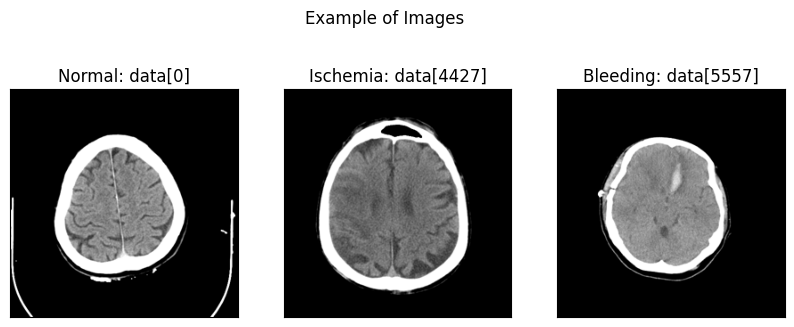

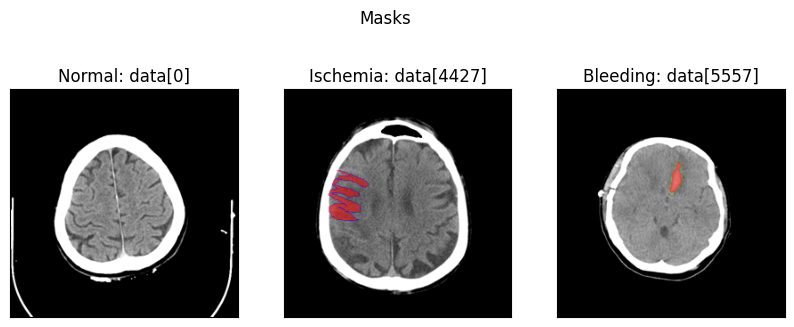

In [8]:
#Mostrmoas una imágen de ejemplo (para ver si el vector y está bien)
f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Example of Images")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(data[0], cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(data[4427], cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(data[5557], cmap="gray")
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


#We will also show the masks of the above pictures (manual)
data0_path =    normal_path    + "/10000.png"
data4427_path = ischemia_mask_path  + "/10003.png"
data5557_path = bleeding_mask_path  + "/10002.png"

mask_data0 = process_image(data0_path, dim, "RGB")
mask_data4427 = process_image(data4427_path, dim, "RGB")
mask_data5557 = process_image(data5557_path, dim, "RGB")

f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Masks")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(mask_data0)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(mask_data4427)
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(mask_data5557)
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


## CNN model

#### Importación de librerías

In [9]:
#Importamos las librerías necesarias

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F  

#### Configuración del dispositivo

In [10]:
# Se establece el dispositivo a utilizar: "cuda" si hay una GPU disponible, de lo contrario "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Preparación y verificación de datos

In [11]:
# Convertimos los datos y etiquetas a tensores de PyTorch
X_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Verificar el tamaño de los tensores
print("Tamaño de X_tensor:", X_tensor.size())
print("Tamaño de y_tensor:", y_tensor.size())

# Contar las muestras por clase
normal_count = (y_tensor == 0).sum().item()  
ischemia_count = (y_tensor == 1).sum().item()  
bleeding_count = (y_tensor == 2).sum().item()  

# Confirmar si coincide con el tamaño de las muestras por clase
print("Normal:", normal_count)
print("Ischemia:", ischemia_count)
print("Bleeding:", bleeding_count)

Tamaño de X_tensor: torch.Size([6650, 256, 256])
Tamaño de y_tensor: torch.Size([6650])
Normal: 4427
Ischemia: 1130
Bleeding: 1093


#### Creación de datasets y DataLoaders

In [12]:
# Creamos un conjunto de datos y un DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Definición del modelo CNN

In [ ]:
# Definimos el modelo CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Capa convolucional 1: toma 1 canal de entrada, produce 32 canales de salida
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  
        # Capa de max pooling: reduce la dimensión espacial de la entrada
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Capa convolucional 2: toma 32 canales de entrada, produce 64 canales de salida
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Capa totalmente conectada 1: toma la salida aplanada y produce 128 salidas
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  
        # Capa totalmente conectada 2: toma 128 entradas y produce 3 salidas (clases)
        self.fc2 = nn.Linear(128, 3)  

    def forward(self, x):
        # Aplicamos la primera capa convolucional seguida de ReLU y max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Aplicamos la segunda capa convolucional seguida de ReLU y max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Aplanamos la salida para que pueda ser procesada por las capas totalmente conectadas
        x = x.view(-1, 64 * 64 * 64)  
        # Aplicamos la primera capa totalmente conectada seguida de ReLU
        x = F.relu(self.fc1(x))
        # Aplicamos la segunda capa totalmente conectada para obtener la salida final
        x = self.fc2(x)
        return x

#### Inicialización del modelo, función de pérdida y optimizador

In [14]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Entrenamiento del modelo

In [15]:
# Entrenamos el modelo
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0                      
    correct = 0                        
    total = 0                            
    for inputs, labels in train_loader:
       inputs, labels = inputs.to(device), labels.to(device)
       optimizer.zero_grad()
       outputs = model(inputs.unsqueeze(1))  # Añadimos una dimensión para el canal
       loss = criterion(outputs, labels) # Calculamos la pérdida
       loss.backward() # Calculamos el gradiente
       optimizer.step() # Actualizamos los pesos
       running_loss += loss.item() * inputs.size(0)        
       _, predicted = torch.max(outputs, 1)               
       correct += (predicted == labels).sum().item()      
       total += labels.size(0)                           
   
    epoch_loss = running_loss / total                       
    epoch_acc = correct / total                               
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%')  


Epoch [1/10], Loss: 0.9799, Accuracy: 69.76%
Epoch [2/10], Loss: 0.3849, Accuracy: 85.73%
Epoch [3/10], Loss: 0.1801, Accuracy: 94.21%
Epoch [4/10], Loss: 0.0787, Accuracy: 97.54%
Epoch [5/10], Loss: 0.0302, Accuracy: 99.08%
Epoch [6/10], Loss: 0.0220, Accuracy: 99.36%
Epoch [7/10], Loss: 0.0134, Accuracy: 99.70%
Epoch [8/10], Loss: 0.0083, Accuracy: 99.79%
Epoch [9/10], Loss: 0.0272, Accuracy: 99.12%
Epoch [10/10], Loss: 0.0042, Accuracy: 99.91%


#### Evaluación del modelo

In [16]:
# Evaluamos el modelo
model.eval()
all_labels = []
all_predictions = []
all_probs = []  # <-- Lista para guardar las probabilidades
correct = 0
total = 0
run_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.unsqueeze(1))  # logits
        
        probs = torch.softmax(outputs, dim=1)  # <-- Probabilidades por clase
        
        loss = criterion(outputs, labels)
        run_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(probs, 1)  # Podrías usar outputs directamente también

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # <-- Guardar las probabilidades

epoch_loss = run_loss / total
epoch_acc = correct / total
print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%')


#print(outputs.data)
#print(predicted)
print(probs)
#print(all_predictions)

Validation Loss: 0.6468, Accuracy: 91.13%
tensor([[1.0000e+00, 5.0398e-20, 5.8057e-17],
        [1.0133e-07, 5.0073e-08, 1.0000e+00],
        [1.0000e+00, 1.2491e-07, 6.3647e-07],
        [3.1652e-01, 6.8346e-01, 2.1983e-05],
        [9.9495e-01, 5.0489e-03, 1.2819e-09],
        [2.0502e-04, 9.9980e-01, 5.1998e-09],
        [4.5269e-06, 6.1357e-07, 9.9999e-01],
        [1.0000e+00, 5.9357e-18, 1.8173e-13],
        [9.9880e-01, 1.2010e-03, 4.2405e-16],
        [1.0000e+00, 1.8507e-14, 1.1660e-13],
        [1.0000e+00, 1.2844e-11, 7.0367e-09],
        [1.0000e+00, 5.6100e-15, 7.0841e-11],
        [5.5704e-01, 4.0217e-01, 4.0794e-02],
        [1.0000e+00, 3.2832e-12, 5.9787e-09],
        [3.0341e-10, 1.0000e+00, 4.5721e-20],
        [9.6691e-01, 3.5308e-05, 3.3056e-02],
        [9.9780e-01, 2.6988e-05, 2.1723e-03],
        [1.0000e+00, 3.2523e-12, 5.2066e-09]])


#### Reporte de métricas y matriz de confusión

Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       0.93      0.96      0.94       890
    Ischemia       0.85      0.80      0.83       210
    Bleeding       0.89      0.84      0.87       230

    accuracy                           0.91      1330
   macro avg       0.89      0.87      0.88      1330
weighted avg       0.91      0.91      0.91      1330



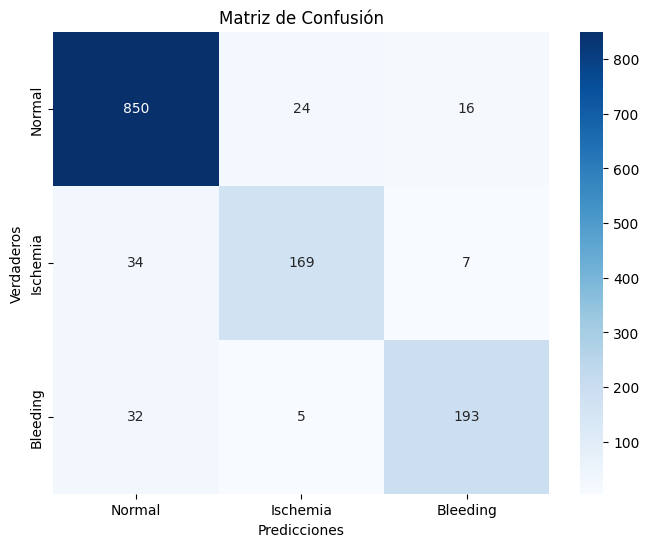

Accuracy para Normal: 95.51%
Accuracy para Ischemia: 80.48%
Accuracy para Bleeding: 83.91%


In [17]:
# Calcular el reporte de clasificación
report = classification_report(all_labels, all_predictions, target_names=["Normal", "Ischemia", "Bleeding"], output_dict=True)

# Imprimir el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(all_labels, all_predictions, target_names=["Normal", "Ischemia", "Bleeding"]))

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Normal", "Ischemia", "Bleeding"], 
            yticklabels=["Normal", "Ischemia", "Bleeding"])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

# Calcular accuracy por clase
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, class_name in enumerate(["Normal", "Ischemia", "Bleeding"]):
    print(f'Accuracy para {class_name}: {class_accuracies[i] * 100:.2f}%')

# Explicabilidad

In [31]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from ipywidgets import interact
from skimage.segmentation import quickshift
import torchvision.transforms as transforms

In [32]:
data = np.array(data)
masks = np.array(masks)

In [33]:
#Slicer to choose an image to explain
#Slicer to choose an image to explain = 10
def show_image(index):
    
    img_to_explain = np.resize(data[index, :], dim)


    if index >= 4427 and index < 5557:
        type = "Ischemia"
        mask_index = index - len(normal_folder)
    
    if index >= 5557:
        type = "Bleeding"
        mask_index = index - len(normal_folder)
    
    f, axes = plt.subplots(1, 2)
    f.set_figheight(4)
    f.set_figwidth(10)
    f.suptitle("Masks " + type)

    axes[0].imshow(img_to_explain, cmap="gray")
    axes[0].set_xticks([])
    axes[0].set_yticks([])


    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].imshow(masks[mask_index].reshape(dim[0], dim[0], 3))
    plt.show()


#show_image(index)
interact(show_image, index=(len(normal_folder), 6549, 1))

interactive(children=(IntSlider(value=5488, description='index', max=6549, min=4427), Output()), _dom_classes=…

<function __main__.show_image(index)>

In [34]:
index_to_explain_ischemia = 4558
index_to_explain_bleeding = 5882

### Ischemia explanation

131


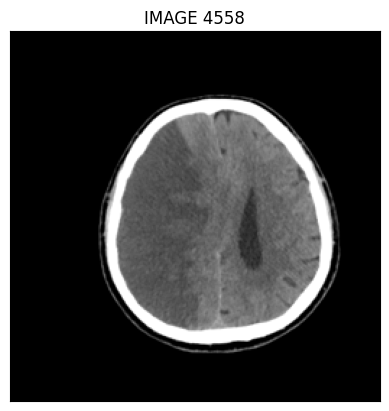

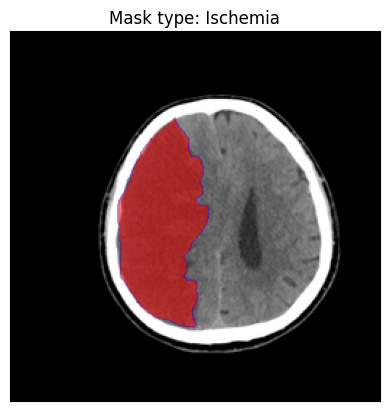

In [35]:
explainer = lime_image.LimeImageExplainer()
index = index_to_explain_ischemia

#Image
img_to_explain = np.resize(data[index, :], dim)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.title("IMAGE " + str(index))
plt.imshow(img_to_explain, cmap="gray")

#Mask
mask_index = 0
type = "Not defined"
if index >= 4427 and index < 5527:
    type =  "Ischemia"
    mask_index = index - len(normal_folder)

elif index >= 5527:
    type = "bleeding"
    mask_index = index -len(normal_folder) - len(ischemia_folder)

print(mask_index)

plt.figure()
plt.title("Mask type: " + type)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[mask_index].reshape((dim[0], dim[1], 3)))
plt.show()


In [36]:
#Lime entragará imágenes perturbadas al modelo y tiene que otorgar un score a cada clase
#print(model(img_to_explain.flatten().reshape(1, -1)))

# Transformación que convierte imagen RGB (aunque sea falsa RGB) a tensor gris
transform = transforms.Compose([
    transforms.ToPILImage(),                  # Convierte np.array a PIL
    transforms.Grayscale(num_output_channels=1), # Asegura que sea 1 canal
    transforms.Resize((256, 256)),            # Asegura tamaño correcto
    transforms.ToTensor(),                    # Convierte a tensor (C, H, W)
])


#Lime entregará imagenes perturbadas que tenemos que procesar antes de pasarselo a nuestro svm
def predict_cnn(images):
    inputs = []
    for img in images:
        tensor_img = transform(img)           # (1, H, W)
        inputs.append(tensor_img)

    batch = torch.stack(inputs)               # (N, 1, H, W)
    batch = batch.to(device)
    
    with torch.no_grad():
        outputs = model(batch)                # (N, num_classes)
        probs = torch.softmax(outputs, dim=1) # Probabilidades

    return probs.cpu().numpy()                # Devuelve np.array a LIME

In [37]:
#Probamos la funcioncita esa 
print(predict_cnn([img_to_explain]))

[[1.6828473e-10 9.9999976e-01 2.9734124e-07]]


In [38]:
# Cambiamos el segmentador para que tenga más superpixeles y se ajuste al sector con ischemia
segmenter = lambda image: quickshift(
    image,
    kernel_size=5,   
    max_dist=200,     
    ratio=3       
)

In [39]:
explanation = explainer.explain_instance(
    img_to_explain,
    predict_cnn,
    top_labels=3,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmenter #Borrar esto para default
)

  0%|          | 0/1000 [00:00<?, ?it/s]

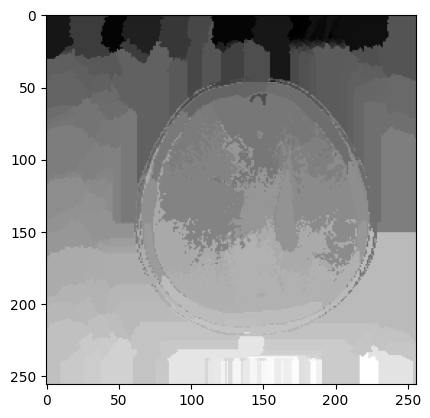

In [40]:
#Mostramos los super pixeles
plt.imshow(explanation.segments, cmap="gray")

In [41]:
#0:normal
#1: Ischemia
#2: Bleeding
explanation.top_labels

[np.int64(1), np.int64(2), np.int64(0)]

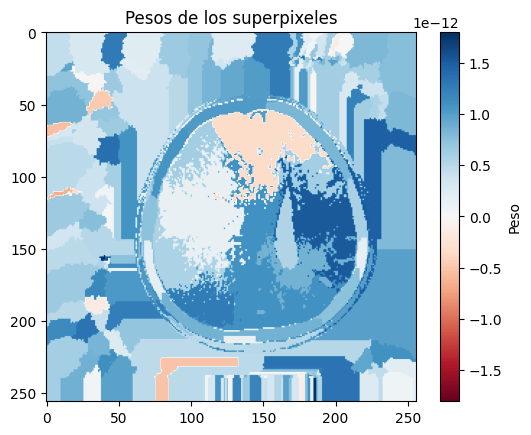

In [42]:
# Seleccionar el índice de la clase que verdaderamente es (posicion 2)
top_class_index = explanation.top_labels[2]

# Extraer los pesos asociados a cada superpixel de la explicación
class_weights = explanation.local_exp[top_class_index]

# Crear un diccionario que mapea los superpixeles a sus pesos
superpixel_weights = dict(class_weights)

# Mapear los pesos a los superpixeles para generar un mapa de calor
heatmap = np.vectorize(superpixel_weights.get)(explanation.segments)

plt.figure()
plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar(label='Peso')
plt.title('Pesos de los superpixeles')
plt.show()

### Bleeding explanation

1455


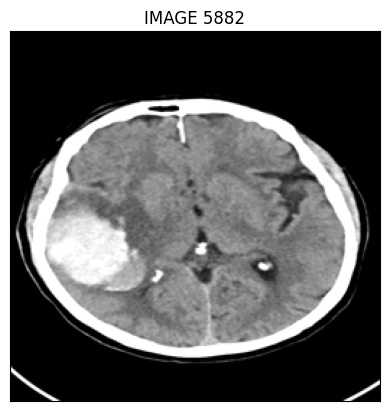

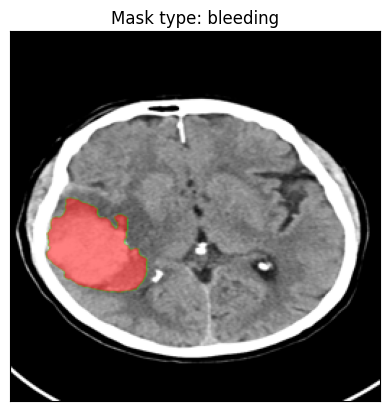

In [43]:
explainer = lime_image.LimeImageExplainer()
index = index_to_explain_bleeding

#Image
img_to_explain = np.resize(data[index, :], dim)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.title("IMAGE " + str(index))
plt.imshow(img_to_explain, cmap="gray")

#Mask
mask_index = 0
type = "Not defined"
if index >= 4427 and index < 5527:
    type =  "Ischemia"
    mask_index = index - len(normal_folder)

elif index >= 5527:
    type = "bleeding"
    mask_index = index -len(normal_folder)

print(mask_index)

plt.figure()
plt.title("Mask type: " + type)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[mask_index].reshape((dim[0], dim[1], 3)))
plt.show()


In [ ]:
#Me faltó correr estooooooo
print(predict_cnn([img_to_explain]))

In [45]:
segmenter = lambda image: quickshift(
    image,
    kernel_size=5,   
    max_dist=200,     
    ratio=3       
)

explanation = explainer.explain_instance(
    img_to_explain,
    predict_cnn,
    top_labels=3,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmenter #Borrar esto para default
)

  0%|          | 0/1000 [00:00<?, ?it/s]

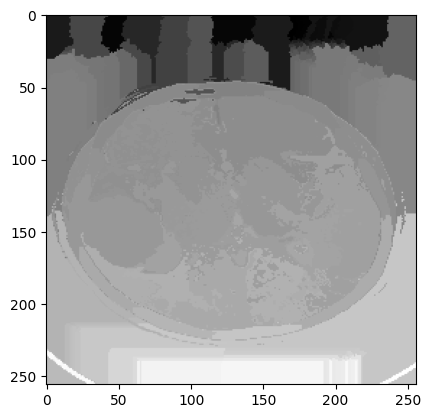

In [46]:
#Mostramos los super pixeles
plt.imshow(explanation.segments, cmap="gray")

In [47]:
#0:normal
#1: Ischemia
#2: Bleeding
explanation.top_labels

[np.int64(1), np.int64(2), np.int64(0)]

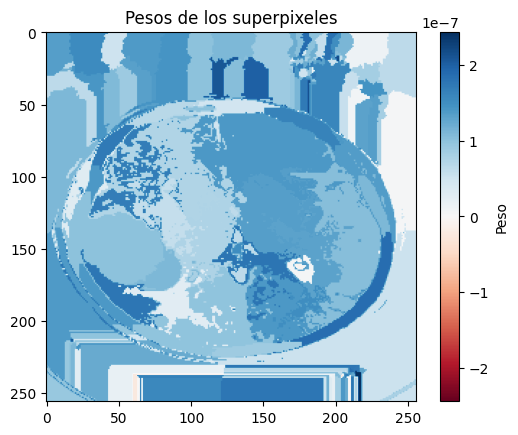

In [48]:
# Seleccionar el índice de la clase que verdaderamente es para explicarla
top_class_index = explanation.top_labels[1]

# Extraer los pesos asociados a cada superpixel de la explicación
class_weights = explanation.local_exp[top_class_index]

# Crear un diccionario que mapea los superpixeles a sus pesos
superpixel_weights = dict(class_weights)

# Mapear los pesos a los superpixeles para generar un mapa de calor
heatmap = np.vectorize(superpixel_weights.get)(explanation.segments)

plt.figure()
plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar(label='Peso')
plt.title('Pesos de los superpixeles')
plt.show()

# Grad-CAM

In [444]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget
from ipywidgets import interact

In [46]:
data = np.array(data)
masks = np.array(masks)

In [47]:
#Slicer to choose an image to explain
#Slicer to choose an image to explain = 10
def show_image(index):
    
    img_to_explain = np.resize(data[index, :], dim)


    if index >= 4427 and index < 5557:
        type = "Ischemia"
        mask_index = index - len(normal_folder)
    
    if index >= 5557:
        type = "Bleeding"
        mask_index = index - len(normal_folder)
    
    f, axes = plt.subplots(1, 2)
    f.set_figheight(4)
    f.set_figwidth(10)
    f.suptitle("Masks " + type)

    axes[0].imshow(img_to_explain, cmap="gray")
    axes[0].set_xticks([])
    axes[0].set_yticks([])


    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].imshow(masks[mask_index].reshape(dim[0], dim[0], 3))
    plt.show()


#show_image(index)
interact(show_image, index=(len(normal_folder), 6549, 1))

interactive(children=(IntSlider(value=5488, description='index', max=6549, min=4427), Output()), _dom_classes=…

<function __main__.show_image(index)>

In [459]:
index_to_explain_ischemia = 4633
index_to_explain_bleeding = 5882

## Grad_CAM Ischemia

206


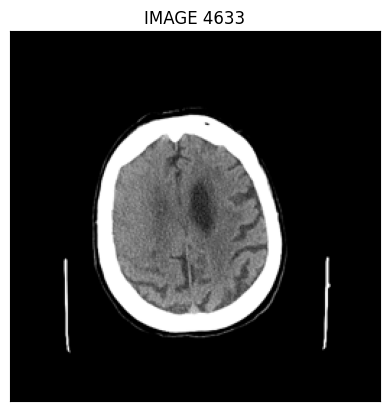

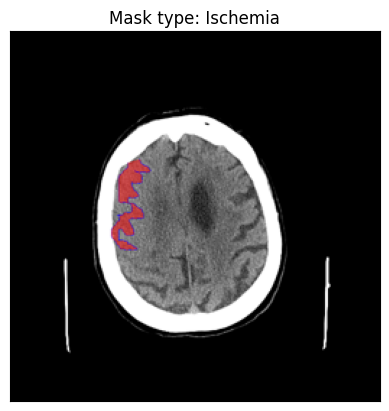

In [460]:
index = index_to_explain_ischemia

#Image
img_to_explain = np.resize(data[index, :], dim)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.title("IMAGE " + str(index))
plt.imshow(img_to_explain, cmap="gray")

#Mask
mask_index = 0
type = "Not defined"
if index >= 4427 and index < 5527:
    type =  "Ischemia"
    mask_index = index - len(normal_folder)

elif index >= 5527:
    type = "bleeding"
    mask_index = index -len(normal_folder) - len(ischemia_folder)

print(mask_index)

plt.figure()
plt.title("Mask type: " + type)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[mask_index].reshape((dim[0], dim[1], 3)))
plt.show()

In [461]:
index = index_to_explain_ischemia

input_tensor = X_tensor[index].unsqueeze(0).to(device)
input_tensor_3ch = input_tensor.repeat(1, 3, 1, 1)

sample_label = y_tensor[index].item()

In [462]:
# Copiar el modelo actual
model_3ch = CNNModel().to(device)
model_3ch.load_state_dict(model.state_dict())  # copiar pesos

# Se modifica la primera capa para aceptar 3 canales (pesos aleatorios)
model_3ch.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1).to(device)

#Se adaptan los pesos de la primera capa a tres canales
with torch.no_grad():
    old_weights = model.conv1.weight  # [32, 1, 3, 3]
    new_weights = old_weights.repeat(1, 3, 1, 1) / 3.0
    model_3ch.conv1.weight.copy_(new_weights)
    if model.conv1.bias is not None:
        model_3ch.conv1.bias.copy_(model.conv1.bias)

In [463]:
# Convertir a numpy (de 0 a 1) para visualizar con show_cam_on_image
input_numpy = input_tensor.squeeze().cpu().numpy()
input_rgb = np.stack([input_numpy]*3, axis=-1)  # convertir a imagen RGB falsa
input_rgb = (input_rgb - input_rgb.min()) / (input_rgb.max() - input_rgb.min() + 1e-8)  # normalizar


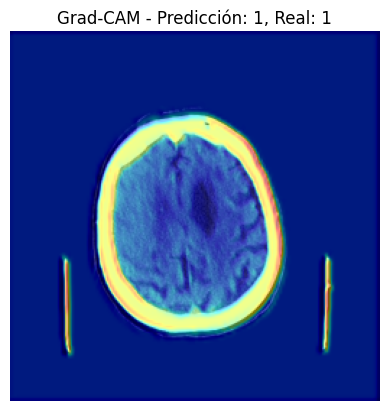

In [464]:

target_layers = [model_3ch.conv2]  # última capa conv
cam = GradCAM(model=model_3ch, target_layers=target_layers)

# Obtener clase predicha

# Ejecutamos una predicción para obtener la clase predicha
model_3ch.eval()
with torch.no_grad():
    output = model_3ch(input_tensor_3ch)
    pred_class = output.argmax(dim=1).item()

# Definimos el objetivo (clase predicha)
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor_3ch, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Visualizar
visualization = show_cam_on_image(input_rgb, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM - Predicción: {pred_class}, Real: {sample_label}")
plt.axis("off")
plt.show()

## Grad_CAM Bleeding

1455


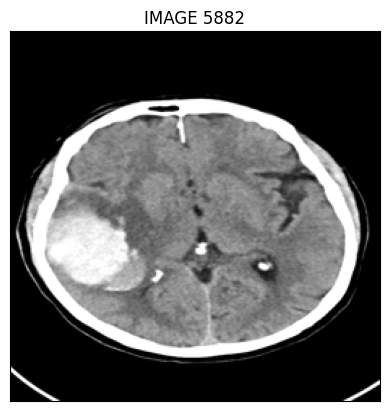

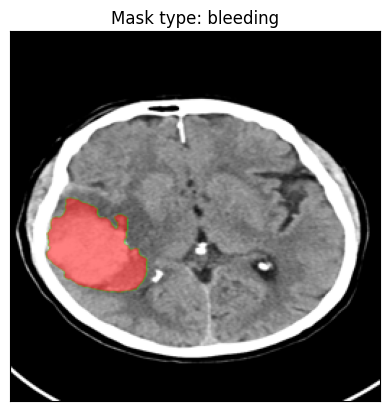

In [454]:

index = index_to_explain_bleeding

#Image
img_to_explain = np.resize(data[index, :], dim)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.title("IMAGE " + str(index))
plt.imshow(img_to_explain, cmap="gray")

#Mask
mask_index = 0
type = "Not defined"
if index >= 4427 and index < 5527:
    type =  "Ischemia"
    mask_index = index - len(normal_folder)

elif index >= 5527:
    type = "bleeding"
    mask_index = index -len(normal_folder)

print(mask_index)

plt.figure()
plt.title("Mask type: " + type)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[mask_index].reshape((dim[0], dim[1], 3)))
plt.show()


In [455]:
index = index_to_explain_bleeding

input_tensor = X_tensor[index].unsqueeze(0).to(device) 
input_tensor_3ch = input_tensor.repeat(1, 3, 1, 1)

sample_label = y_tensor[index].item()

In [456]:
# Copiar el modelo actual
model_3ch = CNNModel().to(device)
model_3ch.load_state_dict(model.state_dict())  # copiar pesos

# Se modifica la primera capa para aceptar 3 canales (pesos aleatorios)
model_3ch.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1).to(device)

#Se adaptan los pesos de la primera capa a tres canales
with torch.no_grad():
    old_weights = model.conv1.weight  # [32, 1, 3, 3]
    new_weights = old_weights.repeat(1, 3, 1, 1) / 3.0
    model_3ch.conv1.weight.copy_(new_weights)
    if model.conv1.bias is not None:
        model_3ch.conv1.bias.copy_(model.conv1.bias)

In [457]:
# Convertir a numpy (de 0 a 1) para visualizar con show_cam_on_image
input_numpy = input_tensor.squeeze().cpu().numpy()
input_rgb = np.stack([input_numpy]*3, axis=-1)  # convertir a imagen RGB falsa
input_rgb = (input_rgb - input_rgb.min()) / (input_rgb.max() - input_rgb.min() + 1e-8)  # normalizar


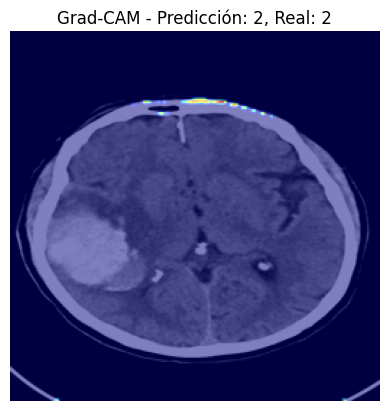

In [458]:

target_layers = [model_3ch.conv2]  # última capa conv
cam = GradCAM(model=model_3ch, target_layers=target_layers)

# Obtener clase predicha

# Ejecutamos una predicción para obtener la clase predicha
model_3ch.eval()
with torch.no_grad():
    output = model_3ch(input_tensor_3ch)
    pred_class = output.argmax(dim=1).item()

# Definimos el objetivo (clase predicha)
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor_3ch, targets=targets)
grayscale_cam = grayscale_cam[0, :]


visualization = show_cam_on_image(input_rgb, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM - Predicción: {pred_class}, Real: {sample_label}")
plt.axis("off")
plt.show()